# Rentals problem

Author: Luís Guilherme Ribeiro

### Importing libraries and data

In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from IPython.display import Image
from scipy.stats import wilcoxon, friedmanchisquare
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

data = pd.read_csv("data/rentals.csv")

## Knowing the data

In [176]:
data.head(5)

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,$170.00
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,$99.00
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,$235.00
3,7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,$65.00
4,8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,$65.00


In [177]:
data = data.set_index('id')

In [178]:
data.describe()

,latitude,longitude,bathrooms,bedrooms,minimum_nights
count,8111.000000,8111.000000,8099.000000,8107.000000,8.111000e+03
mean,37.766054,-122.430107,1.395975,1.345874,1.234526e+04
std,0.022937,0.026967,0.923213,0.925298,1.110357e+06
min,37.704630,-122.513060,0.000000,0.000000,1.000000e+00
25%,37.751450,-122.442830,1.000000,1.000000,2.000000e+00
50%,37.769150,-122.424650,1.000000,1.000000,4.000000e+00
75%,37.785670,-122.410615,1.500000,2.000000,3.000000e+01
max,37.828790,-122.368570,14.000000,14.000000,1.000000e+08


We analyzed the values above, we noticed that some columns we will need to handle them:
 - The price variable there is a '\$' symbol
 - The columns property_type and room_type are categorical variables
 - The other variables are numeric (continous) (bathrooms, bedrooms, minimum_nights)
 - The coordinate variables (latitude and longitude) have a low standard deviation, this shows that the properties are relatively close to each other;

# Handling the variables

## Numeric Variables

### Handling the price variable
We need replace the $ symbol and convert this column to float

In [179]:
data['price'] = data['price'].replace({r'\$':''}, regex = True).replace({r'\,':''}, regex = True).astype(float)
data.describe()

,latitude,longitude,bathrooms,bedrooms,minimum_nights,price
count,8111.000000,8111.000000,8099.000000,8107.000000,8.111000e+03,8111.000000
mean,37.766054,-122.430107,1.395975,1.345874,1.234526e+04,225.407101
std,0.022937,0.026967,0.923213,0.925298,1.110357e+06,412.253039
min,37.704630,-122.513060,0.000000,0.000000,1.000000e+00,0.000000
25%,37.751450,-122.442830,1.000000,1.000000,2.000000e+00,100.000000
50%,37.769150,-122.424650,1.000000,1.000000,4.000000e+00,150.000000
75%,37.785670,-122.410615,1.500000,2.000000,3.000000e+01,240.000000
max,37.828790,-122.368570,14.000000,14.000000,1.000000e+08,10000.000000


### Filtering prices above $25 per nigth

As price values below $25 will not be highly profitable, we will keep records that are greater than this value.


In [180]:
#Prices only above $25
data = data[data['price']>25]
data.describe()

,latitude,longitude,bathrooms,bedrooms,minimum_nights,price
count,8101.000000,8101.000000,8089.000000,8097.000000,8.101000e+03,8101.000000
mean,37.766048,-122.430118,1.396464,1.346548,1.236047e+04,225.667325
std,0.022936,0.026974,0.923679,0.925564,1.111042e+06,412.440788
min,37.704630,-122.513060,0.000000,0.000000,1.000000e+00,27.000000
25%,37.751450,-122.442840,1.000000,1.000000,2.000000e+00,100.000000
50%,37.769150,-122.424670,1.000000,1.000000,4.000000e+00,150.000000
75%,37.785670,-122.410620,1.500000,2.000000,3.000000e+01,240.000000
max,37.828790,-122.368570,14.000000,14.000000,1.000000e+08,10000.000000


Now we have the treated price, and above 25 dollars. Also, we have the minimum_nights variable. So we can create a new variable to find out what the minimum return is:

In [181]:
data['minimum_return'] = data['price']*data['minimum_nights']
data.head(5)

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price,minimum_return
id,,,,,,,,,
958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,170.0,170.0
3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,99.0,99.0
5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,235.0,7050.0
7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,65.0,2080.0
8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,65.0,2080.0


### Handling outliers

When analyzing the values of some continuous variables, we notice that some values are way above normal. So let's create a function to remove possible outliers
of the dataset.

In [182]:
# Function
def fnc_handling_outliers(df, feats, perc):
    df_aux = df
    for f in feats:
        df = df_aux
        quantile = df[f].quantile(perc)
        df_aux = df[df[f] < quantile]
    return df_aux

Now, let´us remove the outliers from continuous variables (except geolocation variables)

In [183]:
# Removing outliers
feats = ['bathrooms', 'bedrooms', 'minimum_nights', 'price']
print(data.shape)
df = fnc_handling_outliers(data,feats,0.985)
print(df.shape)
df.describe()

(8101, 9)
(7447, 9)


,latitude,longitude,bathrooms,bedrooms,minimum_nights,price,minimum_return
count,7447.000000,7447.000000,7447.000000,7447.000000,7447.000000,7447.000000,7447.000000
mean,37.765528,-122.430247,1.252719,1.249765,14.456963,184.191352,2338.810528
std,0.022865,0.027347,0.525841,0.763053,13.848679,126.578765,2822.543477
min,37.704630,-122.513060,0.000000,0.000000,1.000000,27.000000,38.000000
25%,37.751085,-122.442980,1.000000,1.000000,2.000000,100.000000,289.000000
50%,37.767870,-122.424790,1.000000,1.000000,4.000000,150.000000,1047.000000
75%,37.785005,-122.410420,1.500000,2.000000,30.000000,225.000000,3810.000000
max,37.828790,-122.368570,4.000000,3.000000,58.000000,900.000000,26970.000000


Note that when using a quantile of 0.985 it was reduced from 8101 to 7447 records

### Handling Geolocation variables

Let's consider the median value of latitude and longitude to separate possible regions;
So for latitude it was north and south, and for longitude it was separated into east and west;

In [184]:
# The median value of latitude to separate in north ans south
bins_lat = [-np.inf, np.median(df['latitude']), np.inf]
labels_lat = ['south', 'north']
# The median value of longitude to separate in west ans est
bins_lng = [-np.inf, np.median(df['longitude']), np.inf]
labels_lng = ['west', 'est']

# Two new variables of regions
df['region_lat'] = pd.cut(df['latitude'], bins=bins_lat, labels=labels_lat)
df['region_lng'] = pd.cut(df['longitude'], bins=bins_lng, labels=labels_lng)

df

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price,minimum_return,region_lat,region_lng
id,,,,,,,,,,,
958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,170.0,170.0,north,west
3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,99.0,99.0,south,west
5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,235.0,7050.0,south,est
7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,65.0,2080.0,south,west
8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,65.0,2080.0,south,west
...,...,...,...,...,...,...,...,...,...,...,...
39342094,37.74010,-122.41196,House,Private room,2.0,3.0,30,699.0,20970.0,south,est
39343373,37.77799,-122.42159,Condominium,Entire home/apt,1.0,1.0,1,200.0,200.0,north,est
39344101,37.73410,-122.38917,Hut,Private room,2.0,1.0,30,69.0,2070.0,south,est


### Categorial Variables 

We can see that 'property_type' variable has many categories and most of them have few records, so let's create a category called 'Other' to handle this problem

In [185]:
df['property_type'].value_counts()

Apartment             3057
House                 2045
Condominium            812
Guest suite            574
Boutique hotel         256
Hotel                  145
Townhouse              130
Serviced apartment     114
Loft                    83
Hostel                  55
Guesthouse              40
Aparthotel              29
Other                   23
Bed and breakfast       19
Bungalow                17
Resort                  12
Cottage                 12
Villa                    9
Castle                   4
Tiny house               3
Cabin                    3
Earth house              2
Dome house               1
Hut                      1
In-law                   1
Name: property_type, dtype: int64

### Handling property_type

Note that we were able to reduce it to 7 categories, including 'Other'

In [186]:
# Get the counts of each category
top = df['property_type'].value_counts()[:6].index
df.loc[~df['property_type'].isin(top), 'property_type'] = 'Other'
df['property_type'].value_counts()

Apartment         3057
House             2045
Condominium        812
Guest suite        574
Other              558
Boutique hotel     256
Hotel              145
Name: property_type, dtype: int64

In the variable 'room_type' everything is ok

In [187]:
df['room_type'].value_counts()

Entire home/apt    4365
Private room       2723
Shared room         187
Hotel room          172
Name: room_type, dtype: int64

### Encoding categorical variables

As we will need to use categorical variables in a model, so we will need to encode so that the model can train

In [188]:
ordinal_encoder = OrdinalEncoder()
df["property_type_encoded"] = ordinal_encoder.fit_transform(df.loc[:,'property_type'].values.reshape(-1,1))
df[['property_type','property_type_encoded']]

,property_type,property_type_encoded
id,,
958,Apartment,0.0
3850,House,5.0
5858,Apartment,0.0
7918,Apartment,0.0
8142,Apartment,0.0
...,...,...
39342094,House,5.0
39343373,Condominium,2.0
39344101,Other,6.0


In [189]:
ordinal_encoder = OrdinalEncoder()
df['room_type_encoded'] = ordinal_encoder.fit_transform(df.loc[:,'room_type'].values.reshape(-1,1))
df[['room_type','room_type_encoded']]

,room_type,room_type_encoded
id,,
958,Entire home/apt,0.0
3850,Private room,2.0
5858,Entire home/apt,0.0
7918,Private room,2.0
8142,Private room,2.0
...,...,...
39342094,Private room,2.0
39343373,Entire home/apt,0.0
39344101,Private room,2.0


In [190]:
df['region_north'] = pd.get_dummies(df['region_lat'], drop_first=True)
df[['region_lat','region_north']].head()

,region_lat,region_north
id,,
958,north,1
3850,south,0
5858,south,0
7918,south,0
8142,south,0


### Exploratoty Data Analysis

### Person correlation

<AxesSubplot:>

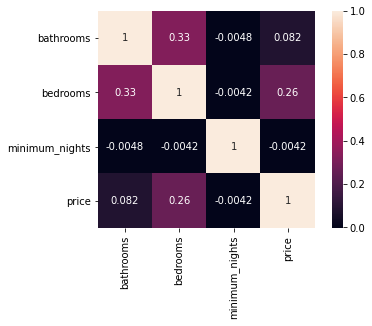

In [191]:
#Pearson correlation
corr = data[['bathrooms','bedrooms','minimum_nights', 'price']].corr()
sns.heatmap(corr, annot=True, square=True)


We can see that the 'bedrooms' variable has the most positive correlation with 'price', that is, the greater the number of bedrooms, the higher the property price

### Violin plot on categorial variables

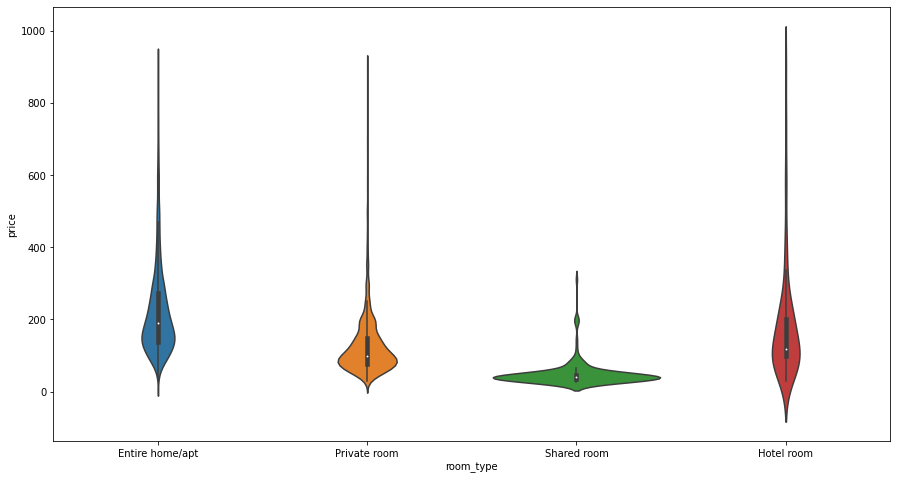

In [192]:
plt.figure(figsize=(15,8))
sns.violinplot(x='room_type', y='price', data=df)
plt.show()

When analyzing the variable 'room_type' we notice that the 'shared room' has the lowest prices. Furthermore, 'emtire home' and 'Hotel room' tend to be priced higher than the other categories.

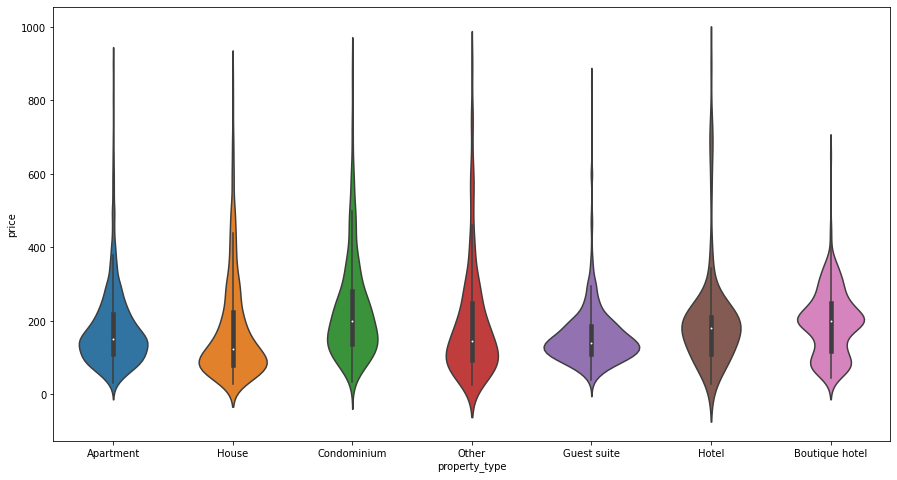

In [193]:
plt.figure(figsize=(15,8))
sns.violinplot(x='property_type', y='price', data=df)
plt.show()

When analyzing the variable 'property_type' we noticed the categories 'Boutique hotel' and 'Hotel' tend to have the highest prices.
  Unlike the 'Guest Suite', 'House' and 'Other' categories, which tend to have the lowest prices;

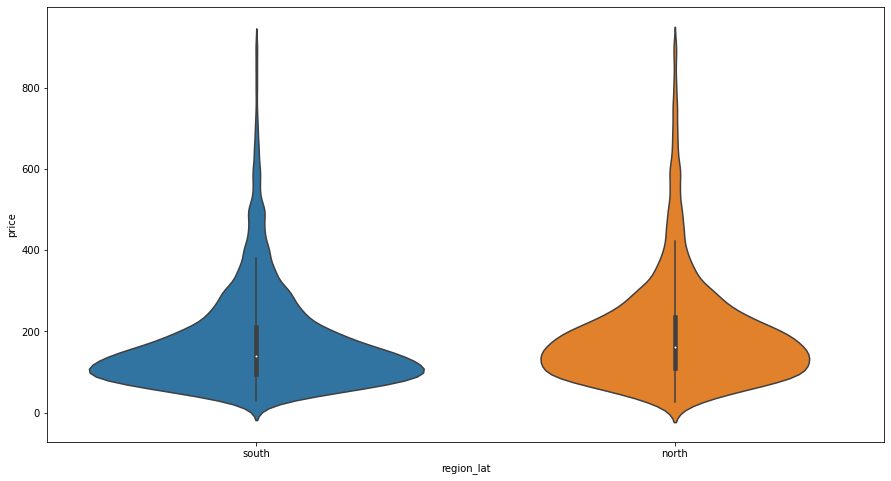

In [194]:
plt.figure(figsize=(15,8))
sns.violinplot(x='region_lat', y='price', data=df)
plt.show()

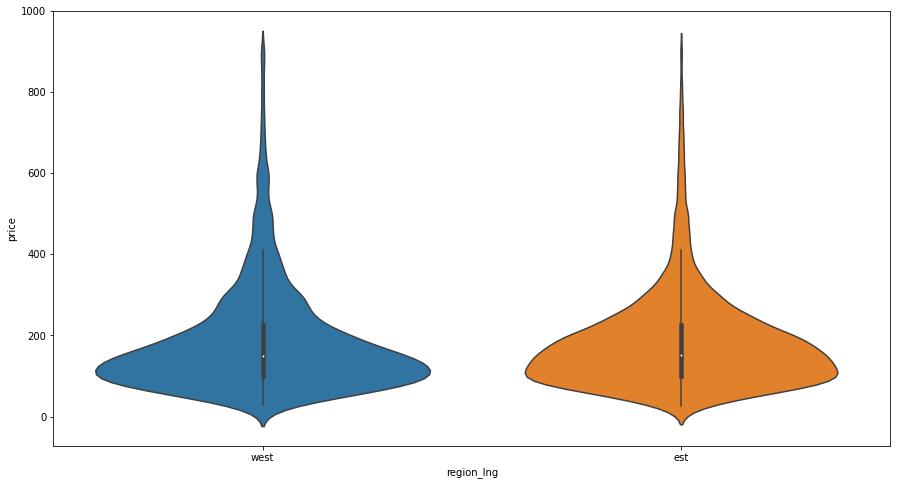

In [195]:
plt.figure(figsize=(15,8))
sns.violinplot(x='region_lng', y='price', data=df)
plt.show()

When comparing prices by region, we noticed that the variable 'region_lat' shows that the northern region has a greater volume of high prices than the southern region.
However, for the variable 'region_lng' the parts are graphically similar from one region to another.
So, let's just consider the variable 'region_lat' when training our model

### Data to models

In [196]:
features = ['bathrooms','bedrooms','minimum_nights','room_type_encoded', 'property_type_encoded', 'region_north', 'price']
df_model = df[features]
X = df_model.drop(['price'], axis=1)
y = df_model['price']

## Evaluation

### Regression Evaluation Metrics


To compare the performance of models let's use metrics

- **Coefficient of determination** (R-squared) represents the coefficient of how well the values fit compared to the original values. The value from 0 to 1 interpreted as percentages. The higher the value is, the better the model is;
- **Mean Absolute Error** (MAE) represents the difference between the original and predicted values extracted by averaged the absolute difference over the data set;
- **Mean Squared Error** (MSE) represents the difference between the original and predicted values extracted by squared the average difference over the data set;
- **Root Mean Squared Error** (RMSE) is the error rate by the square root of MSE;

in the image below is listed as formulas for each metric:

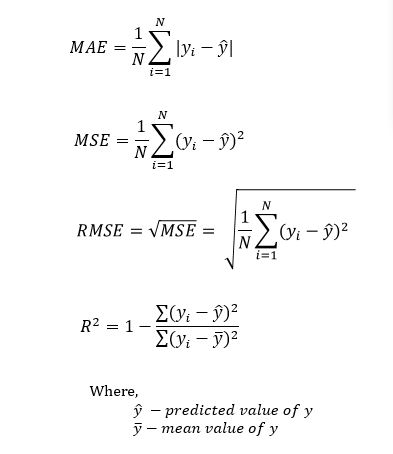

In [197]:
Image(filename='formulas.JPG') 

### Regression Models

In [198]:
# Models
lr_pipe = Pipeline(steps=[('modelo',LinearRegression())])
rf_pipe = Pipeline(steps=[('modelo', RandomForestRegressor())])
et_pipe = Pipeline(steps=[('modelo', ExtraTreesRegressor())])
xgb_pipe = Pipeline(steps=[('modelo', XGBRegressor())])

models = [
    ['LinearRegression', lr_pipe],
    ['RandomForest', rf_pipe],
    ['ExtraTrees', et_pipe],
    ['XGBoost', xgb_pipe]
]


## Outcomes

#### Cross Validation

In [ ]:
results_means = []
results_details = []
for m in models:
    print('\n'+m[0])
    scores_r2 = cross_val_score(m[1], X, y, cv=5, scoring='r2')
    scores_mae = cross_val_score(m[1], X, y, cv=5, scoring='neg_mean_absolute_error')
    scores_mse = cross_val_score(m[1], X, y, cv=5, scoring='neg_mean_squared_error')
    scores_rmse = cross_val_score(m[1], X, y, cv=5, scoring='neg_root_mean_squared_error')
    r2 = round(np.mean(scores_r2),4)
    mae = round(np.mean(scores_mae)*-1,4)
    mse = round(np.mean(scores_mse)*-1,4)
    rmse = round(np.mean(scores_rmse)*-1,4)
    print('R2: ',r2)
    print('MAE: ',mae)
    print('MSE: ',mse)
    print('RMSE: ',rmse)
    results_means.append([m[0], r2, mae, mse, rmse])
    results_details.append([m[0], scores_r2, scores_mae, scores_mse, scores_rmse])


LinearRegression
R2:  0.4411
MAE:  64.5254
MSE:  8926.4075
RMSE:  94.4086

RandomForest
R2:  0.4523
MAE:  59.105
MSE:  8739.1062
RMSE:  93.4886

ExtraTrees
R2:  0.4264
MAE:  59.7659
MSE:  9138.3682
RMSE:  95.4487

XGBoost


In [ ]:
df_results = pd.DataFrame (results_means, columns = ['models','r2','mae','mse','rmse'])

In [ ]:
plt.figure(figsize = (15, 9))
plt.bar(df_results['models'], df_results['r2'], width = 0.4)
plt.xlabel("Models")
plt.ylabel("R-Square (average)")
plt.title("Evaluation regression models")
plt.show()

When we compare the r-square, we see that the XGBoost and RandomForest models have the best performance

In [ ]:
plt.figure(figsize=(15,8))
X = df_results['models']
y_mae = df_results['mae']
y_rmse = df_results['rmse']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, y_mae, 0.4, label = 'MAE')
plt.bar(X_axis + 0.2, y_rmse, 0.4, label = 'RMSE')
  
plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("Number of Students")
plt.title("Number of Students in each group")
plt.legend()
plt.show()

When comparing in terms of error (MAE and RMSE) we see that XGBoost has the best performance, with 58.86 of MAE

### Statistical test 

Let's apply the wilcoxon test between XGBoost and RF to check if there was statistical difference between r-square and MAE metrics

In [ ]:
#
alfa = 0.05 # 95% of confidence

rf_r2 = results_details[1][1] #RF R2
rf_mae = results_details[1][2] #RF MAE
xgb_r2 = results_details[3][1] #XGB R2
xgb_mae = results_details[3][1] #XGB MAE

print('\n\nR-Square')
stat, p = wilcoxon(rf_r2, xgb_r2)
print('p-value = %.4f ' % p)
if p > alfa:
    print('There was no statistical difference')
else:
    print('There was statistical difference')
    
print('\n\nMAE')
stat, p = wilcoxon(rf_mae, xgb_mae)
print('p-value = %.4f ' % p)
if p > alfa:
    print('There was no statistical difference')
else:
    print('There was statistical difference')

### Conclusion

In the test it was shown that there was no statistical difference in the performance of the RandomForest and XGBoost models

## Future Works

- Explore new variables that can help improve price prediction.
- Compare new regression models, with different approaches;
- Build a data pipeline to put the model into production;

- Explore more features that can contribute to model performance
- Approach new regression models, like ensemble models based on voting
- Create a pipeline data to put the model in production
